# Infer ***soma*** -  1️⃣ 
(🚨🚨🚨🚨 Steps 2-9 depend on establishing a good solution here.)

--------------

## OBJECTIVE: ✅ Infer sub-cellular component soma in order to understand interactome 

>> WARNING:  THIS DOES NOT WORK WELL

To measure shape, position, and size of the cell body -- the soma.    There are a variety of signals from which we could make this inference.  The two most promising are a composite signal including the residual from linear unmixing (e.g. `ch = [1, 4, 5,7]`) and a signal derived from the lysosome channel (`ch = 1`).    In all procdures scaling the intensities to find the lower florescence signals at the edge of the soma against baseline is employed.  

In the long term we can build of a database of "ground truth" by sourcing additional markers which can be iteratively improved.  For example using the Allen Cell "Label Free" segmentation results should provide a good corroboration or constraints to the procedures outlined below.  

A first possible _workflow_ is illustrated below.






# IMPORTS

In [48]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np

from scipy import ndimage as ndi
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling

from skimage import filters
from skimage.segmentation import watershed
from skimage.morphology import remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.utils.file_io import (read_czi_image,
                                                                    list_image_files)

from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )                                                                    
from infer_subc_2d.utils.img import *

from infer_subc_2d.organelles import fixed_get_optimal_Z_image, fixed_find_optimal_Z, find_optimal_Z

%load_ext autoreload
%autoreload 2

test_img_n = TEST_IMG_N

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IMAGE PROCESSING  OBJECTIVE :  infer ***soma***
 
> #### Note:  we are using the Nuclei of the brightest cell to aid in inferring the Soma and Cytosol objects.   Because we do NOT have a direct cell membrane / soma signal this is the trickiest and potentially problematic part of the overall sub-cellular component inference.   The Soma (via the Cytosol mask) will be used to define ALL subsequent sub-cellular Objects.

------------------------
# LOAD RAW IMAGE DATA
Identify path to _raw_ image data and load our example image


In [49]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]


In [50]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## Get default parameters, including  "optimal" Z

takes ~ 4 seconds to calculate

In [51]:

ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 




## get the inferred nuclei object

(takes < 1 sec)

Note the several helper functions below for extracting the signal.

In [5]:


# img_2D = img_data[:,[optimal_Z],:,:].copy()

img_2D = fixed_get_optimal_Z_image(img_data)


In [6]:

img_2D = select_z_from_raw(img_data, optimal_Z)


# IMAGE PROCESSING PROTOTYPE, Objective 2:  infer ***soma***

>WORKFLOW #1  - modified MCZ 3/20

Segmentation on a 3 channel composite as per 3/20 pipeline from MCZ
Summary - Starting with a linear combination of three signals,  the signal is smoothed and non-linearly combined (logrithmic and edge detected) for thresholding. 
## summary of steps

➡️ INPUT
- multi-channel sum (4*1,5,7)
- labeled NUCLEI (objective #1)

PRE-PROCESSING
- ne-noise and somoothe
- log transform inensities
- scale to max 1.0
- create non-linear aggregate of log-intensity + scharr filtered 

CORE PROCESSING
- mask object segmentation at bottom

POST-PROCESSING
  - fill holes
  - remove small objects

POST-PROCESSING
  - keep only the "most intense" Soma


OUTPUT ➡️ 
- mask of SOMA


### INPUT

In [7]:

###################
# INPUT
###################
struct_img_raw = (4. * img_2D[LYSO_CH].copy() + 
                               1. * img_2D[ER_CH].copy() + 
                               1. * img_2D[RESIDUAL_CH].copy() )


nuc_img_raw = img_2D[NUC_CH].copy() 

In [8]:
def _raw_soma_MCZ(img_in):
    """ define soma image
    """
    SOMA_W = (4.,1.,1.)
    SOMA_CH = (LYSO_CH,ER_CH,RESIDUAL_CH) #LYSO, ER, RESIDUAL
    img_out = np.zeros_like(img_in[0]).astype(np.double)
    for w,ch in zip(SOMA_W,SOMA_CH):
        img_out += w*img_in[ch]
    return img_out

_struct_img_raw = _raw_soma_MCZ(img_2D)


### PRE-PROCESSING


In [9]:

###################
# PRE_PROCESSING
###################
#
# DEFAULT PARAMETERS:
#intensity_norm_param = [0.5, 15]
gaussian_smoothing_sigma = 1.
gaussian_smoothing_truncate_range = 3.0

med_filter_size = 15  

################# part 1
raw_soma_linear = min_max_intensity_normalization(struct_img_raw.copy())

struct_img = median_filter_slice_by_slice(raw_soma_linear, size=med_filter_size)

structure_img_smooth = ndi.gaussian_filter( struct_img,
                                                                                sigma=gaussian_smoothing_sigma,
                                                                                mode="nearest", 
                                                                                truncate=gaussian_smoothing_truncate_range,
                                                                                )


# NON-Linear aggregation
log_image, d = log_transform( structure_img_smooth ) 
log_image = intensity_normalization(  log_image,  scaling_param=[0] )

edges = filters.scharr(log_image)

composite_soma = intensity_normalization(  edges,  scaling_param=[0] ) + log_image 


intensity normalization: min-max normalization with NO absoluteintensity upper bound
intensity normalization: min-max normalization with NO absoluteintensity upper bound


In [10]:
def _non_linear_soma_transform_MCZ(in_img):
    """ non-linear distortion to fill out soma
    log + edge of smoothed composite
    """
    # non-Linear processing
    log_img, d = log_transform( in_img.copy() ) 
    log_img = min_max_intensity_normalization(  log_img )
    return min_max_intensity_normalization(  filters.scharr(log_img) )  + log_img

_composite_soma = _non_linear_soma_transform_MCZ(structure_img_smooth)


In [11]:

################# part 2 Nuclei pre=process
nuc_img_raw = img_2D[0].copy() 
# median filter in 2D / convert to float 0-1.   get rid of the "residual"
nuclei = min_max_intensity_normalization(nuc_img_raw)

med_filter_size = 4   
# structure_img_median_3D = ndi.median_filter(struct_img,    size=med_filter_size  )
nuclei = median_filter_slice_by_slice( 
                                                                nuclei,
                                                                size=med_filter_size  )

gaussian_smoothing_sigma = 1.34
gaussian_smoothing_truncate_range = 3.0
nuclei = image_smoothing_gaussian_slice_by_slice(  nuclei,
                                                                                            sigma=gaussian_smoothing_sigma,
                                                                                            truncate_range = gaussian_smoothing_truncate_range
                                                                                            )





In [12]:

def _masked_object_thresh(
    structure_img_smooth: np.ndarray, th_method: str, cutoff_size: int, th_adjust: float
) -> np.ndarray:
    """
    wrapper for applying Masked Object Thresholding with just two parameters via `MO` from `aicssegmentation`
    Parameters
    ------------
    structure_img_smooth: np.ndarray
        a 3d image
    th_method: str
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    cutoff_size: int
        Masked Object threshold `size_min`
    th_adjust: float
        Masked Object threshold `local_adjust`

    Returns
    -------------
        np.ndimage

    """

    struct_obj = MO(
        structure_img_smooth,
        global_thresh_method=th_method,
        object_minArea=cutoff_size,
        extra_criteria=True,
        local_adjust=th_adjust,
        return_object=False,
        dilate=True,
    )
    return struct_obj


### CORE PROCESSING

In [16]:
###################
# CORE_PROCESSING
###################
low_level_min_size =  100

################# part 1
bw = _masked_object_thresh(composite_soma, 
                                                th_method='ave', 
                                                cutoff_size=low_level_min_size, 
                                                th_adjust= 0.5)
# "Masked Object Thresholding" - 3D
# bw, _bw_low_level = MO(composite_soma, 
#                                                 global_thresh_method='ave', 
#                                                 object_minArea=low_level_min_size, 
#                                                 extra_criteria=True,
#                                                 local_adjust= 0.5, 
#                                                 return_object=True,
#                                                 dilate=True)
                                                

################# part 2 : nuclei thresholding
#struct_obj = struct_img > filters.threshold_li(struct_img)
thresh_factor = 0.9 #from cellProfiler
thresh_min = .1
thresh_max = 1.
NU_object = apply_log_li_threshold(nuclei, thresh_factor=thresh_factor, thresh_min=thresh_min, thresh_max=thresh_max)

hole_width = 5  
# # wrapper to remoce_small_objects
NU_object = remove_small_holes(NU_object, hole_width ** 2 )

small_object_width = 20
NU_object = size_filter_2D(NU_object, 
                                                            min_size= small_object_width**2, 
                                                            connectivity=1)



NU_label = label(NU_object)



### POST-PROCESSING

In [17]:
###################
# POST_PROCESSING
###################

# 2D 
hole_width = 40
#removed_holes = remove_small_holes(bw, hole_width ** 2 )
removed_holes = hole_filling(bw, hole_min =0 , hole_max=hole_width**2, fill_2d = True) 


small_object_width = 45
cleaned_img = size_filter_2D(removed_holes, 
                                                            min_size= small_object_width**2, 
                                                            connectivity=1)

# limit the labeling to where we have soma or NUclear signal
# watershed_mask = np.logical_or(cleaned_img, NU_labels > 0)
watershed_mask = cleaned_img 
inverted_img = 1. - composite_soma

labels_out = watershed(
            inverted_img,
            markers=NU_label,
            connectivity=np.ones((1, 3,3), bool),
            mask=watershed_mask,
            )



In [18]:
def _masked_inverted_watershed(img_in,markers, mask):
    """wrapper for watershed on inverted image and masked

    """
    labels_out = watershed(
                1. - img_in,
                markers=markers,
                connectivity=np.ones((1, 3,3), bool),
                mask=mask,
                )
    return labels_out




In [19]:
_labels_out = _masked_inverted_watershed(composite_soma,NU_label, cleaned_img)

labels_out.shape, NU_label.shape

((1, 768, 768), (1, 768, 768))

In [20]:
###################
# POST- POST_PROCESSING
###################
# keep the "SOMA" label which contains the highest total signal
all_labels = np.unique(labels_out)[1:]

total_signal = [ raw_soma_linear[labels_out == label].sum() for label in all_labels]
# combine NU and "labels" to make a SOMA
keep_label = all_labels[np.argmax(total_signal)]
keep_label

soma_out = np.zeros_like(labels_out)
soma_out[labels_out==keep_label] = 1

In [21]:
def _choose_max_label(raw_signal: np.ndarray, labels_in: np.ndarray):
    """ keep only the label with the maximum raw signal

    """

    all_labels = np.unique(labels_in)[1:]

    total_signal = [ raw_signal[labels_in == label].sum() for label in all_labels]
    # combine NU and "labels" to make a SOMA
    keep_label = all_labels[np.argmax(total_signal)]

    labels_max = np.zeros_like(labels_in)
    labels_max[labels_in==keep_label] = 1
    return labels_max

_soma_out = _choose_max_label(raw_soma_linear,labels_out)

#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [22]:

viewer = napari.view_image(
        cleaned_img,
        scale=scale
    )


In [23]:


viewer.scale_bar.visible = True
viewer.add_labels(
    labels_out,
    scale=scale 
)

viewer.add_labels(
    soma_out,
    scale=scale 
)

<Labels layer 'soma_out' at 0x1774713a0>

In [24]:
viewer.add_image(
    NU_object,
    scale=scale
)
viewer.add_labels(
    _soma_out,
    scale=scale 
)

<Labels layer '_soma_out' at 0x1773e7370>

In [25]:
viewer.add_labels(
    _labels_out,
    scale=scale 
)

<Labels layer '_labels_out' at 0x181a29b80>

## DEFINE `_fixed_infer_soma` function

Based on the _prototyping_ above define the function to infer soma. with a *fixed* set of parameters for each step in the procedure.  That is they are all "hard coded"

## DEFINE parameterized  `_infer_soma` function

A function to infer_soma from our (Channel, 1 Z slice, X, Y) image accourding the the following parameters: 
-  

In [27]:
##########################
# 1. infer_soma
##########################

def _infer_soma(in_img: np.ndarray,
    median_sz_soma: int,
    gauss_sig_soma: float,
    median_sz_nuc: int,
    gauss_sig_nuc: float,
    mo_method: str,
    mo_adjust: float,
    mo_cutoff_size: int,
    thresh_factor: float,
    thresh_min: float,
    thresh_max: float,
    max_hole_w_nuc: int,
    small_obj_w_nuc: int,
    max_hole_w_soma: int,
    small_obj_w_soma: int
) -> np.ndarray:
    """
    Procedure to infer soma from linearly unmixed input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    median_sz_soma: int
        width of median filter for _soma_ signal
    gauss_sig_soma: float
        sigma for gaussian smoothing of _soma_ signal
    median_sz_nuc: int
        width of median filter for _soma_ signal
    gauss_sig_nuc: float
        sigma for gaussian smoothing of _soma_ signal
    mo_method: str
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: float
        Masked Object threshold `local_adjust`
    mo_cutoff_size: int
        Masked Object threshold `size_min`
    thresh_factor: float
        adjustment factor for log Li threholding
    thresh_min: float
        abs min threhold for log Li threholding
    thresh_max: float
        abs max threhold for log Li threholding
    max_hole_w_nuc: int
        hole filling cutoff for nuclei post-processing
    small_obj_w_nuc: int
        minimu object size cutoff for nuclei post-processing
    max_hole_w_soma: int
        hole filling cutoff for soma signal post-processing
    small_obj_w_soma: int
        minimu object size cutoff for soma signal post-processing

    Returns
    -------------
    soma_mask: np.ndarray
        a logical/labels object defining boundaries of soma

    """
    nuc_ch = NUC_CH
    ###################
    # EXTRACT
    ###################
    struct_img = _raw_soma_MCZ(in_img)

    nuclei = select_channel_from_raw(in_img, nuc_ch)
    nuclei = min_max_intensity_normalization(nuclei)

    ###################
    # PRE_PROCESSING
    ###################                         
    ################# part 1- soma

    struct_img = min_max_intensity_normalization(struct_img)
    
    # make a copy for post-post processing
    scaled_signal = struct_img.copy()

    # Linear-ish processing
    struct_img = median_filter_slice_by_slice(struct_img, size=median_sz_soma)

    struct_img = image_smoothing_gaussian_slice_by_slice( struct_img,
                                                                                sigma=gauss_sig_soma)

    struct_img_non_lin = _non_linear_soma_transform_MCZ(struct_img)

    ################# part 2 - nuclei

    nuclei = median_filter_slice_by_slice( nuclei,
                                                                    size=median_sz_nuc  )

    nuclei = image_smoothing_gaussian_slice_by_slice(  nuclei,
                                                                                                sigma=gauss_sig_nuc )


    ###################
    # CORE_PROCESSING
    ###################
    struct_obj = _masked_object_thresh(struct_img_non_lin, 
                                                th_method=mo_method, 
                                                cutoff_size=mo_cutoff_size, 
                                                th_adjust=mo_adjust)               
    # # "Masked Object Thresholding" - 3D capable
    # struct_obj = MO(
    #     struct_img_non_lin, 
    #     object_minArea=mo_cutoff_size, 
    #     global_thresh_method=mo_method, 
    #     local_adjust=mo_adjust, 
    #     return_object=False
    # )
    ################# part 2 : nuclei thresholding
    nuclei_object = apply_log_li_threshold(nuclei, thresh_factor=thresh_factor, thresh_min=thresh_min, thresh_max=thresh_max)

    # # wrapper to remoce_small_objects
    nuclei_object = hole_filling(nuclei_object, hole_min=0, hole_max=max_hole_w_nuc**2, fill_2d=True)

    nuclei_object = size_filter_2D(nuclei_object, 
                                                                min_size= small_obj_w_nuc**2, 
                                                                connectivity=1)


    nuclei_labels = label(nuclei_object)
    ###################
    # POST_PROCESSING
    ###################
    struct_obj = hole_filling(struct_obj, 
                                                hole_min =0 , 
                                                hole_max=max_hole_w_soma**2, 
                                                fill_2d = True) 
 
    struct_obj = size_filter_2D(struct_obj, 
                                                    min_size= small_obj_w_soma**2, 
                                                    connectivity=1)

    labels_out = _masked_inverted_watershed(struct_img, nuclei_labels, struct_obj) # np.logical_or(struct_obj, NU_labels > 0)

    ###################
    # POST- POST_PROCESSING
    ###################
    # keep the "SOMA" label which contains the highest total signal
    soma_out = _choose_max_label(struct_img,labels_out)

    return soma_out




In [62]:
1200**.5

34.64101615137755

: 

##  `_fixed_infer_soma` function

For better maintainability lets refactor the _fixed_ version to simply call `_infer_soma`

In [28]:
##########################
# 1. fixed_infer_soma
##########################


def _fixed_infer_soma(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer soma from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    Returns
    -------------
    soma_mask: np.ndarray
        a logical/labels object defining boundaries of soma
    """
    

    ###################
    # PARAMETERS
    ###################   
    median_sz_soma = 15
    gauss_sig_soma = 1.34
    median_sz_nuc = 4
    gauss_sig_nuc = 1.34
    mo_method = "ave"
    mo_adjust = 0.5
    mo_cutoff_size = 100
    thresh_factor = 0.9
    thresh_min = 0.1
    thresh_max = 1.
    max_hole_w_nuc = 5
    small_obj_w_nuc = 15
    max_hole_w_soma = 40
    small_obj_w_soma = 15

    soma_out = _infer_soma(in_img,
                                                median_sz_soma,
                                                gauss_sig_soma,
                                                median_sz_nuc,
                                                gauss_sig_nuc,
                                                mo_method,
                                                mo_adjust,
                                                mo_cutoff_size,
                                                thresh_factor,
                                                thresh_min,
                                                thresh_max,
                                                max_hole_w_nuc,
                                                small_obj_w_nuc,
                                                max_hole_w_soma,
                                                small_obj_w_soma) 

    return soma_out




---------------------
# TEST `_infer_soma`  function defined above


##


In [29]:

SO_label =  _fixed_infer_soma(img_2D) 

In [30]:
from infer_subc_2d.organelles import fixed_infer_soma, infer_soma

soma_ =  fixed_infer_soma(img_2D) 

In [31]:
viewer.add_image(
    SO_label,
    scale=scale
)
viewer.add_image(
    soma_,
    scale=scale 
)

<Image layer 'soma_' at 0x181c0b850>

Write the `infer_soma` spec to the widget json

In [32]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_soma =  {
        "name": " infer soma mask (fixed parameters)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "fixed_infer_soma",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_soma", _fixed_infer_soma, overwrite=True)

function fixed_infer_soma is already in all_functions.json
overwriting  fixed_infer_soma


1

In [33]:

_infer_soma =  {
        "name": " infer soma mask",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_soma",
        "parameters": {
                "median_sz_soma": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 3,
                        "max": 15,
                        "increment": 1
                },
                "gauss_sig_soma": {
                        "data_type": "float",
                        "increment": 0.25,
                        "max": 15.0,
                        "min": 1.25,
                        "widget_type": "slider"
                },
                "median_sz_nuc": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 3,
                        "max": 15,
                        "increment": 1
                },
                "gauss_sig_nuc": {
                        "data_type": "float",
                        "increment": 0.25,
                        "max": 15.0,
                        "min": 1.25,
                        "widget_type": "slider"
                },
                "mo_method": {
                        "data_type": "str",
                        "widget_type": "drop-down",
                        "options": [
                                "triangle",
                                "median",
                                "ave_tri_med"
                                ]
                },
                "mo_adjust": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.0,
                        "min": 0.0,
                        "widget_type": "slider"
                },
                "mo_cutoff_size": {
                        "data_type": "int",
                        "increment": 10,
                        "max": 250,
                        "min": 10,
                        "widget_type": "slider"
                },
                "thresh_factor": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.2,
                        "min": 0.6,
                        "widget_type": "slider"
                },
                "thresh_min": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": .9,
                        "min": 0.0,
                        "widget_type": "slider"
                },
                "thresh_max": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.0,
                        "min": 0.1,
                        "widget_type": "slider"
                },
                "max_hole_w_nuc": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 40,
                        "min": 4,
                        "widget_type": "slider"
                },           
                "small_obj_w_nuc": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                },                           
                "max_hole_w_soma": {
                        "data_type": "int",
                        "increment": 2,
                        "max": 100,
                        "min": 20,
                        "widget_type": "slider"
                },           
                "small_obj_w_soma": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                },        
        }
}

add_function_spec_to_widget_json("infer_soma", _infer_soma, overwrite=True )



function infer_soma is already in all_functions.json
overwriting  infer_soma


1

In [34]:

_raw_soma_MCZ =  {
        "name": "define weighted aggregate soma signal (MCZ-cellprofiler)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "raw_soma_MCZ",
        "parameters": None
        }

add_function_spec_to_widget_json("raw_soma_MCZ", _raw_soma_MCZ, overwrite=True)

function raw_soma_MCZ is already in all_functions.json
overwriting  raw_soma_MCZ


1

In [35]:

_non_linear_soma_transform_MCZ =  {
        "name": "non-linear filter of soma signal (MCZ-cellprofiler)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "non_linear_soma_transform_MCZ",
        "parameters": None
        }

add_function_spec_to_widget_json("non_linear_soma_transform_MCZ", _non_linear_soma_transform_MCZ)

function non_linear_soma_transform_MCZ is already in all_functions.json


0

In [36]:

_masked_inverted_watershed =  {
        "name": "watershed on inverted image and masked",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "masked_inverted_watershed",
        "parameters": None
        }

add_function_spec_to_widget_json("masked_inverted_watershed", _masked_inverted_watershed)

function masked_inverted_watershed is already in all_functions.json


0

In [37]:

_choose_max_label =  {
        "name": "keep only the label with the maximum raw signa",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "choose_max_label",
        "parameters": None
        }

add_function_spec_to_widget_json("choose_max_label", _choose_max_label)

function choose_max_label is already in all_functions.json


0

In [38]:

_min_max_intensity_normalization =  {
        "name": "Min Max Intesity Normalization",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "min_max_intensity_normalization",
        "parameters": None
        }

add_function_spec_to_widget_json("min_max_intensity_normalization", _min_max_intensity_normalization)

function min_max_intensity_normalization is already in all_functions.json


0

In [39]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_masked_object_thresh =  {
        "name": "Masked Object Threshold wrapper for widgets",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "masked_object_thresh",
        "parameters": {
                "th_method": {
                        "data_type": "str",
                        "widget_type": "drop-down",
                        "options": [
                        "triangle",
                        "median",
                        "ave_tri_med"
                        ]
                },
                "cutoff_size": {
                        "data_type": "int",
                        "widget_type": "slider",
                        "min": 0,
                        "max": 2000,
                        "increment": 50
                },
                "th_adjust": {
                        "data_type": "float",
                        "widget_type": "slider",
                        "min": 0,
                        "max": 2,
                        "increment": 0.02
                }
        }
}

add_function_spec_to_widget_json("masked_object_thresh", _masked_object_thresh, overwrite=True)

function masked_object_thresh is already in all_functions.json
overwriting  masked_object_thresh


1

--------------------------

# TEST `infer_soma` exported functions


##
`infer_som a` procedure

In [40]:
from infer_subc_2d.organelles import fixed_infer_soma

soma_mask =  fixed_infer_soma(img_2D) 

In [41]:
# viewer = napari.Viewer()

viewer.scale_bar.visible = True

viewer.add_labels(
    soma_mask,
    scale=scale,
    blending='additive'
)


<Labels layer 'soma_mask' at 0x181e06fa0>

-------------------------------
## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [58]:
def make_infer_soma_step_by_step_dict():
    """
    Procedure to infer nuclei from linearly unmixed input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    soma_mask: np.ndarray
        mask

    Returns
    -------------
    nuclei_object
        mask defined extent of NU

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []

    ###################
    # EXTRACT
    ###################   
    # struct_img = _raw_soma_MCZ(in_img)
    step_name.append("1")
    function_name.append("raw_soma_MCZ")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = NUC_CH) )
    parent.append(0)

    ###################
    # PRE_PROCESSING
    ###################
    #SOMA
    step_name.append("3")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(1)


    step_name.append("4")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 15 ))
    parent.append(3)


    step_name.append("5")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.4 ))
    parent.append(4)

    step_name.append("6")
    function_name.append("non_linear_soma_transform_MCZ")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(5)

    #NUC
    step_name.append("7")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(2)

    step_name.append("8")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 4 ))
    parent.append(7)

    step_name.append("9")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.4 ))
    parent.append(8)

    ###################
    # CORE_PROCESSING
    ###################
    # SOMA
    step_name.append("10")
    function_name.append("masked_object_thresh")
    category.append("core")
    parameter_values.append(dict( th_method="ave_tri_med",
                                                            cutoff_size = 100,
                                                            th_adjust = 0.5))
    parent.append(6)


    # NUCLEI
    step_name.append("11")
    function_name.append("apply_log_li_threshold")
    category.append("core")
    parameter_values.append(dict(thresh_factor = 0.9, 
                                                            thresh_min = .1,
                                                            thresh_max = 1.))
    parent.append(9)


    ###################
    # POST_PROCESSING
    ###################
    # NUCLEI
    step_name.append("12")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=5**2, fill_2d=True))
    parent.append(11)

    step_name.append("13")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 15**2  ))
    parent.append(12)

    step_name.append("14")
    function_name.append("label")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append(13)

    # SOMA
    step_name.append("15")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=25**2, fill_2d=True))
    parent.append(10)

    step_name.append("16")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 15**2  ))
    parent.append(15)

    step_name.append("17")
    function_name.append("masked_inverted_watershed")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([ 5 , 14, 16])

    ###################
    # POST- POST_PROCESSING
    ###################
    # keep the "SOMA" label which contains the highest total signal
    step_name.append("18")
    function_name.append("choose_max_label")
    category.append("postpostprocessing")
    parameter_values.append(None)
    parent.append([5, 17])

    ##########################
    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
        
    return out_dict

In [59]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_soma_stepbystep_dict = make_infer_soma_step_by_step_dict()

write_workflow_json("conf_2.1.soma_stepbystep", infer_soma_stepbystep_dict )

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_2.1.soma_stepbystep.json')

In [60]:
def make_infer_soma_step_by_step_from_raw_dict():
    """
    Procedure to infer nuclei from linearly unmixed input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    soma_mask: np.ndarray
        mask

    Returns
    -------------
    nuclei_object
        mask defined extent of NU

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []

    ###################
    # EXTRACT
    ###################   
    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    # SOMA
    step_name.append("2")
    function_name.append("raw_soma_MCZ")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(1)

    # NUC
    step_name.append("3")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = NUC_CH) )
    parent.append(1)

    ###################
    # PRE_PROCESSING
    ###################
    # SOMA
    step_name.append("4")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(2)

    step_name.append("5")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 15 ))
    parent.append(4)

    step_name.append("6")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.4 ))
    parent.append(5)

    step_name.append("7")
    function_name.append("non_linear_soma_transform_MCZ")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(6)

    #NUC
    step_name.append("8")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(3)

    step_name.append("9")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 4 ))
    parent.append(8)

    step_name.append("10")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.4 ))
    parent.append(9)

    ###################
    # CORE_PROCESSING
    ###################
    # SOMA
    step_name.append("11")
    function_name.append("masked_object_thresh")
    category.append("core")
    parameter_values.append(dict( th_method="ave_tri_med",
                                                            cutoff_size = 100,
                                                            th_adjust = 0.5))
    parent.append(7)

    # NUC
    step_name.append("12")
    function_name.append("apply_log_li_threshold")
    category.append("core")
    parameter_values.append(dict(thresh_factor = 0.9, 
                                                            thresh_min = .1,
                                                            thresh_max = 1.))
    parent.append(10)

    ###################
    # POST_PROCESSING
    ###################
    # nUC
    step_name.append("13")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=5**2, fill_2d=True))
    parent.append(12)

    step_name.append("14")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 15**2  ))
    parent.append(13)

    step_name.append("15")
    function_name.append("label")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append(14)


    # SOMA
    step_name.append("16")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=25**2, fill_2d=True))
    parent.append(11)

    step_name.append("17")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 15**2  ))
    parent.append(16)

    step_name.append("18")
    function_name.append("masked_inverted_watershed")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([  7 , 15,17 ])

    ###################
    # POST- POST_PROCESSING
    ###################
    # keep the "SOMA" label which contains the highest total signal
    step_name.append("19")
    function_name.append("choose_max_label")
    category.append("postpostprocessing")
    parameter_values.append(None)
    parent.append([6,18])

    ##########################
    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
        
    return out_dict

In [61]:

infer_soma_stepbystep_from_raw_dict = make_infer_soma_step_by_step_from_raw_dict()

write_workflow_json("conf_1.1.soma_stepbystep_from_raw", infer_soma_stepbystep_from_raw_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_1.1.soma_stepbystep_from_raw.json')

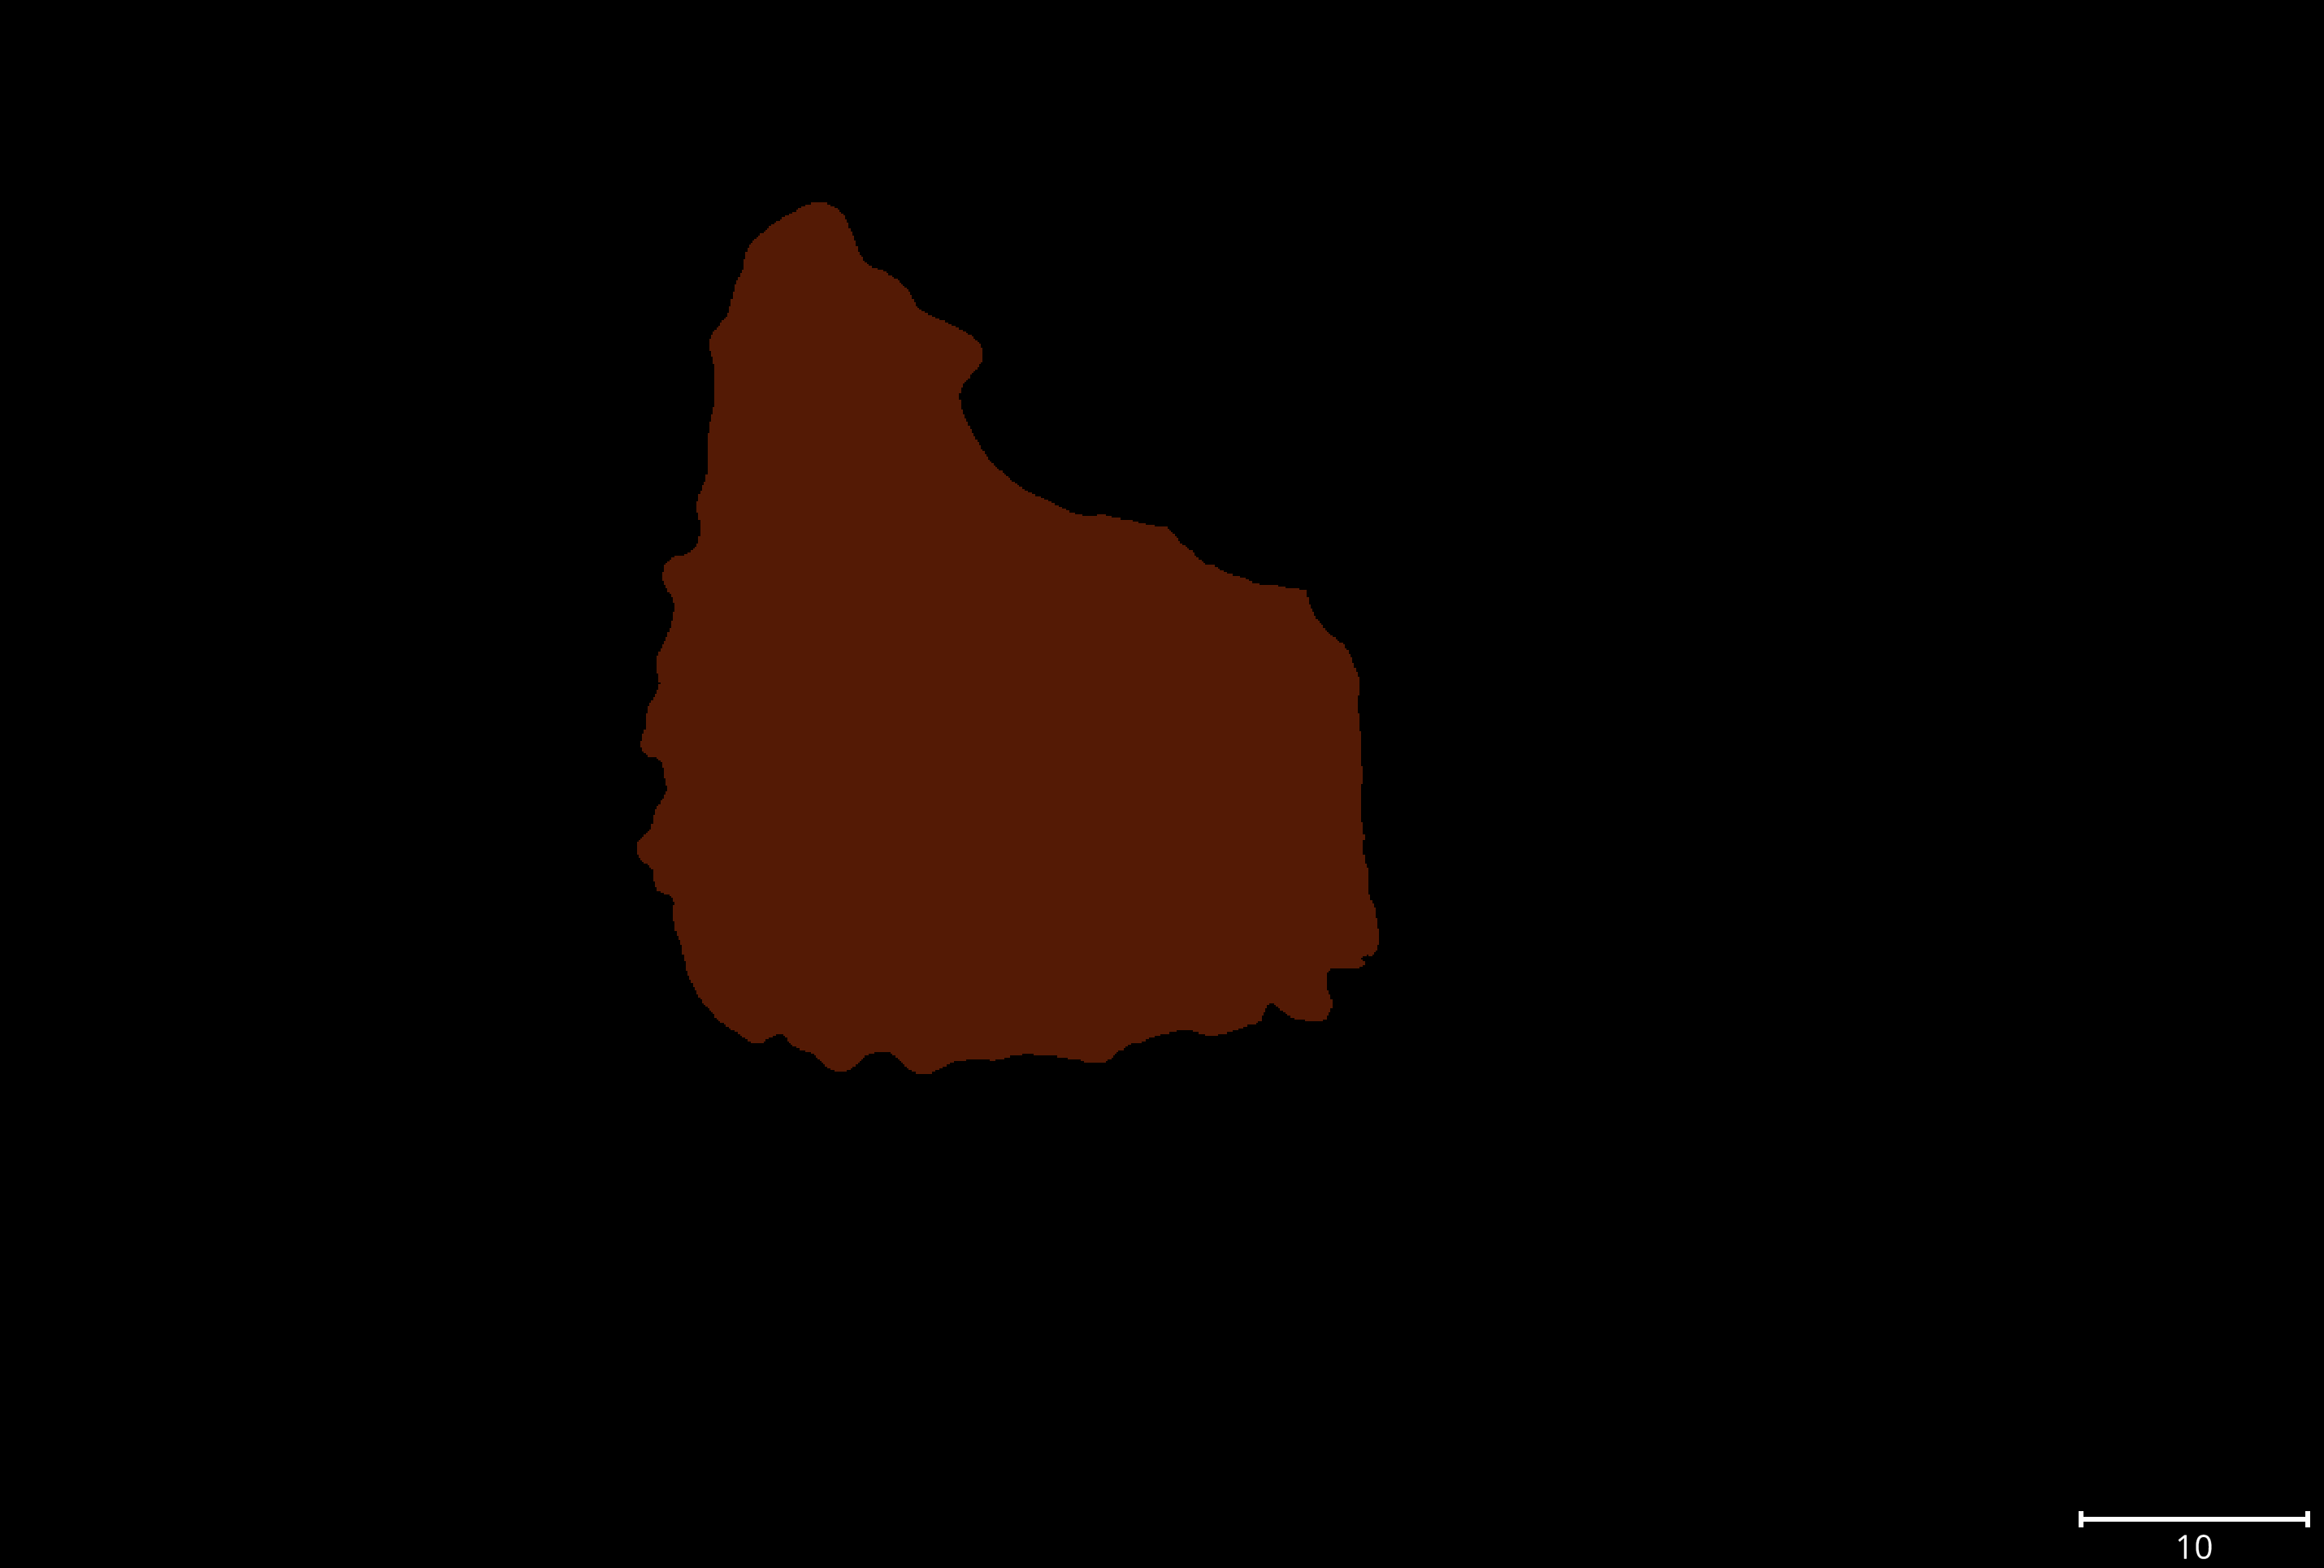

In [43]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [47]:
viewer.close()